In [1]:
#################################
# 1. IMPORTS & CONFIG
#################################
import os
import gc
import cv2
import torch
import random
import numpy as np
import pandas as pd

from glob import glob
from torch import nn
from tqdm import tqdm
from sklearn.model_selection import KFold
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as T

from google.colab import drive
from sklearn.metrics import f1_score
import torch.cuda.amp as amp



In [2]:
import kagglehub

# This is the dataset ID from your link
path = kagglehub.dataset_download("wadhasnalhamdan/date-fruit-image-dataset-in-controlled-environment")

print("Dataset path:", path)


100%|██████████| 3.11G/3.11G [00:32<00:00, 104MB/s] 

Extracting files...


Dataset path: /root/.cache/kagglehub/datasets/wadhasnalhamdan/date-fruit-image-dataset-in-controlled-environment/versions/1


In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(root=path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

print("Classes:", dataset.classes)


Classes: ['Ajwa', 'Galaxy', 'Medjool', 'Meneifi', 'Nabtat Ali', 'Rutab', 'Shaishe', 'Sokari', 'Sugaey']


In [4]:
from torch.utils.data import random_split

# 80% train, 20% validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)




In [5]:
class CFG:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    epochs = 7
    lr = 0.001


In [6]:
#################################
# efficientnet_b0
#################################
class DateClassifier(nn.Module):
    def __init__(self, num_classes=9 , pretrained=True):
        super(DateClassifier, self).__init__()
        self.model = torchvision.models.efficientnet_b0(pretrained=pretrained)
        self.model.classifier = nn.Sequential(
            nn.Linear(self.model.classifier[1].in_features, 512),
            nn.BatchNorm1d(512),  # Batch Normalization added here
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes),
            nn.BatchNorm1d(num_classes),  # Batch Normalization added here
        )

    def forward(self, x):
        return self.model(x)


In [7]:
#################################
# 6. TRAINING FUNCTION
#################################
def train_fn(train_loader, model, criterion, optimizer, scheduler):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(CFG.device), labels.to(CFG.device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    return total_loss / len(train_loader), train_acc

In [8]:
#################################
# 6. VALIDATION FUNCTION
#################################
def eval_fn(val_loader, model, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images = images.to(CFG.device)
            labels = labels.to(CFG.device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    return total_loss / len(val_loader), val_acc


In [9]:

# 7. TRAINING LOOP
model = DateClassifier(num_classes=len(dataset.classes), pretrained=True).to(CFG.device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) # Example scheduler

best_val_accuracy = 0.0
best_model_state_dict = None

for epoch in range(CFG.epochs):
    print(f"Epoch {epoch+1}/{CFG.epochs}")

    train_loss, train_acc = train_fn(train_loader, model, criterion, optimizer, scheduler)
    val_loss, val_acc = eval_fn(val_loader, model, criterion)

    print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"  Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

    # Save the best model based on validation accuracy
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        best_model_state_dict = model.state_dict()
        print(f"  Validation accuracy improved. Saving model with accuracy: {best_val_accuracy:.4f}")
        # Optionally save the model file here as well
        # torch.save(model.state_dict(), 'best_model.pth')


# After the training loop, you can load the best model state dict
if best_model_state_dict is not None:
    # Create a new model instance
    final_model = DateClassifier(num_classes=len(dataset.classes), pretrained=True).to(CFG.device)

    # Load the best weights
    final_model.load_state_dict(best_model_state_dict)

    # Save the model permanently
    torch.save(final_model.state_dict(), 'best_model.pth')

    print("Loaded the best model state dictionary and saved to 'best_model.pth'")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 103MB/s]


Epoch 1/7


100%|██████████| 11/11 [00:44<00:00,  4.04s/it]


  Train Loss: 0.7772, Train Accuracy: 0.8560
  Validation Loss: 0.4635, Validation Accuracy: 0.9488
  Validation accuracy improved. Saving model with accuracy: 0.9488
Epoch 2/7


100%|██████████| 11/11 [00:46<00:00,  4.24s/it]


  Train Loss: 0.4741, Train Accuracy: 0.9630
  Validation Loss: 0.3602, Validation Accuracy: 0.9759
  Validation accuracy improved. Saving model with accuracy: 0.9759
Epoch 3/7


100%|██████████| 11/11 [00:45<00:00,  4.13s/it]


  Train Loss: 0.3944, Train Accuracy: 0.9789
  Validation Loss: 0.3004, Validation Accuracy: 0.9940
  Validation accuracy improved. Saving model with accuracy: 0.9940
Epoch 4/7


100%|██████████| 11/11 [00:46<00:00,  4.25s/it]


  Train Loss: 0.3750, Train Accuracy: 0.9759
  Validation Loss: 0.3023, Validation Accuracy: 0.9880
Epoch 5/7


100%|██████████| 11/11 [00:45<00:00,  4.17s/it]


  Train Loss: 0.3631, Train Accuracy: 0.9744
  Validation Loss: 0.2689, Validation Accuracy: 0.9849
Epoch 6/7


100%|██████████| 11/11 [00:46<00:00,  4.21s/it]


  Train Loss: 0.3083, Train Accuracy: 0.9804
  Validation Loss: 0.2184, Validation Accuracy: 0.9940
Epoch 7/7


100%|██████████| 11/11 [00:47<00:00,  4.29s/it]


  Train Loss: 0.2964, Train Accuracy: 0.9872
  Validation Loss: 0.2977, Validation Accuracy: 0.9789
Loaded the best model state dictionary and saved to 'best_model.pth'


In [10]:

if best_model_state_dict is None:
    print("No best model state dictionary found from training. Skipping inference.")
else:
    # Load the best model for inference
    final_model = DateClassifier(num_classes=len(dataset.classes), pretrained=True).to(CFG.device)
    final_model.load_state_dict(best_model_state_dict)
    final_model.eval() # Set model to evaluation mode

    predictions = []
    true_labels = []

    print("Starting inference on validation data...")

    # Use the validation loader for inference (assuming it covers your test set requirements)
    # If you have a separate test dataset, create a new DataLoader for it
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images = images.to(CFG.device)
            labels = labels.to(CFG.device)

            outputs = final_model(images)
            preds = torch.argmax(outputs, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Convert predictions to class names if needed
    predicted_classes = [dataset.classes[p] for p in predictions]
    true_classes = [dataset.classes[t] for t in true_labels]


    # Example: Save predictions to a file
    submission_df = pd.DataFrame({
        'TrueLabel': true_classes,
        'PredictedLabel': predicted_classes
    })

    # Save the dataframe to a CSV file
    submission_file_path = 'SUBMISSION.csv'
    submission_df.to_csv(submission_file_path, index=False)

    print(f"Inference complete. Predictions saved to {submission_file_path}")

    # Optional: Calculate F1 score
    # f1 = f1_score(true_labels, predictions, average='weighted') # or 'macro', 'micro'
    # print(f"Weighted F1 Score on validation data: {f1:.4f}")

Starting inference on validation data...


100%|██████████| 11/11 [00:45<00:00,  4.16s/it]

Inference complete. Predictions saved to SUBMISSION.csv


Displaying 10 random images with their inferred labels from the submission dataframe.


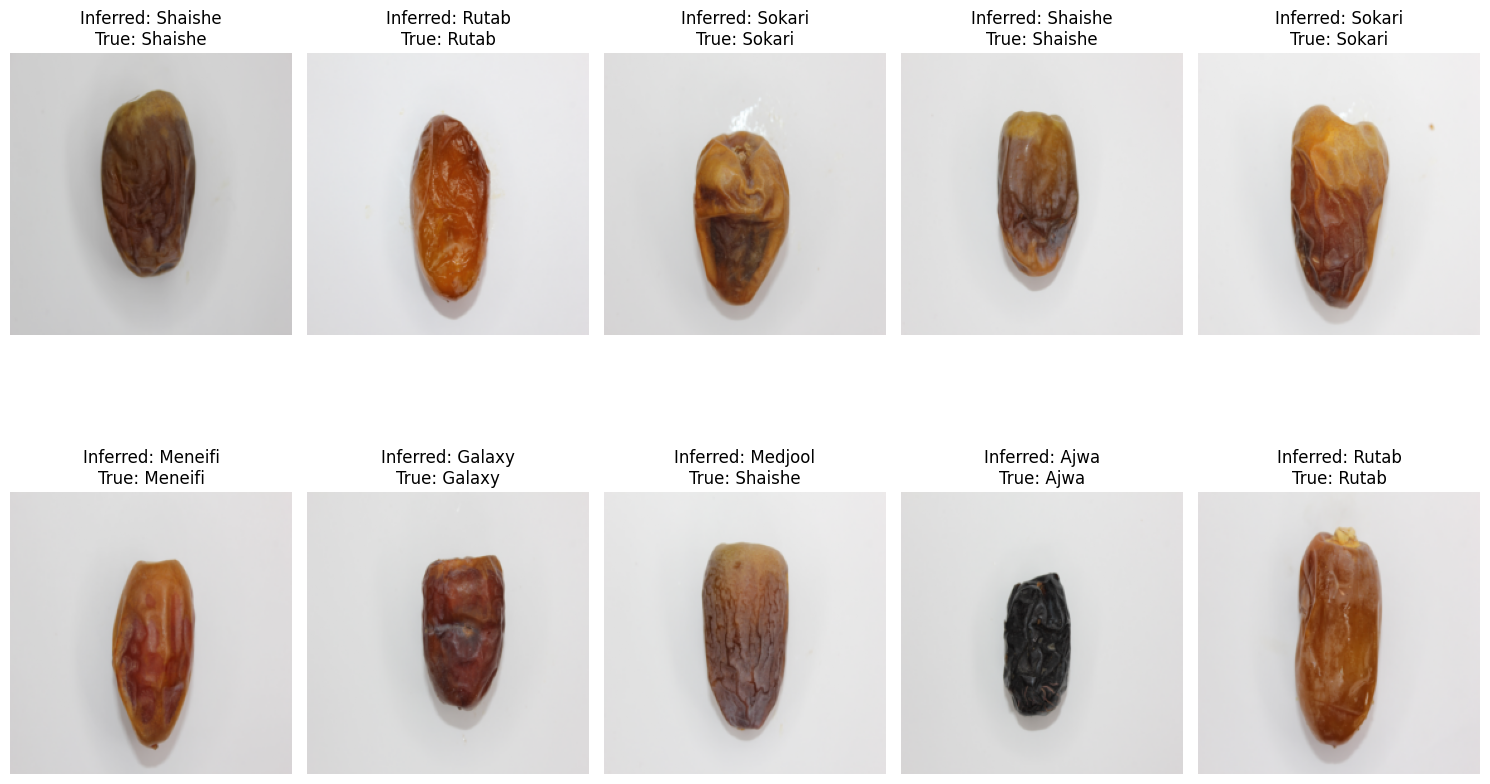

In [11]:

import matplotlib.pyplot as plt

# Assuming you have a DataFrame named `submission_df` and the `val_dataset` is still available

if 'submission_df' in locals() and 'val_dataset' in locals():
    print("Displaying 10 random images with their inferred labels from the submission dataframe.")

    # Get a list of indices from the validation dataset
    # We need to map the index in the submission_df back to the index in the original dataset
    # that corresponds to the validation split.
    # The val_dataset object has a `indices` attribute which holds the original dataset indices.
    val_indices = val_dataset.indices

    # Select 10 random indices from the validation split
    random_val_indices = random.sample(range(len(val_indices)), min(10, len(val_indices)))

    plt.figure(figsize=(15, 10))

    for i, val_split_idx in enumerate(random_val_indices):
        # Get the corresponding original dataset index
        original_dataset_idx = val_indices[val_split_idx]

        # Retrieve the image and true label from the validation dataset
        # val_dataset[val_split_idx] gives (image_tensor, label_index)
        image_tensor, true_label_idx = val_dataset[val_split_idx]

        # Convert the image tensor to a numpy array for displaying
        # Permute dimensions from (C, H, W) to (H, W, C) for matplotlib
        image_np = image_tensor.permute(1, 2, 0).numpy()

        # Get the inferred label from the submission_df based on the validation split index
        # The submission_df rows correspond to the order of samples in val_loader (which is val_dataset).
        inferred_label_name = submission_df.iloc[val_split_idx]['PredictedLabel']
        true_label_name = dataset.classes[true_label_idx] # Get true class name using original dataset class list

        plt.subplot(2, 5, i + 1)
        plt.imshow(image_np)
        plt.title(f"Inferred: {inferred_label_name}\nTrue: {true_label_name}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("Submission DataFrame or Validation Dataset not found. Please run the inference part first.")


In [12]:


# Check if the best_model_state_dict exists and is not None
if 'best_model_state_dict' in locals() and best_model_state_dict is not None:
    # Define the path where you want to save the model
    model_save_path = 'best_date_classifier_model.pth'

    # Save the state dictionary
    torch.save(best_model_state_dict, model_save_path)

    print(f"Best model state dictionary saved to {model_save_path}")

    # Download the saved file
    from google.colab import files
    files.download(model_save_path)
else:
    print("No best model state dictionary was found. Make sure the training loop completed successfully.")


Best model state dictionary saved to best_date_classifier_model.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install gradio wikipedia

import gradio as gr
import wikipedia
from PIL import Image
import torch
import torchvision.transforms as transforms

# Define the classes (assuming these are the same as used in your model)
classes = ['Ajwa', 'Galaxy', 'Medjool', 'Meneifi', 'Nabtat Ali', 'Rutab', 'Shaishe', 'Sokari', 'Sugaey']

# Load the saved model state dictionary
# Ensure 'best_model.pth' exists and is the path to your trained model
model_path = 'best_model.pth'
try:
    # Create a new instance of the model architecture
    model = DateClassifier(num_classes=len(classes), pretrained=False).to(CFG.device) # Set pretrained=False when loading weights

    # Load the state dictionary
    model.load_state_dict(torch.load(model_path, map_location=torch.device(CFG.device)))
    model.eval() # Set model to evaluation mode
    print(f"Model loaded successfully from {model_path}")
except FileNotFoundError:
    print(f"Error: Model file not found at {model_path}. Please ensure the training and saving process completed successfully.")
    model = None # Set model to None if loading fails

# Define the image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # Add normalization if your training data was normalized
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def classify_date_and_get_description(image):
    if model is None:
        return "Model not loaded.", "Please ensure the model file exists and is correctly loaded."

    try:
        # Convert the Gradio Image to a PIL Image if needed
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image.astype('uint8'), 'RGB')

        # Apply transformations
        image = transform(image).unsqueeze(0).to(CFG.device) # Add batch dimension

        # Make a prediction
        with torch.no_grad():
            outputs = model(image)
            _, predicted_idx = torch.max(outputs, 1)
            predicted_class = classes[predicted_idx.item()]

        # Get description from Wikipedia
        try:
            # Search Wikipedia for the date type
            page = wikipedia.page(f"{predicted_class} date", auto_suggest=True)
            description = page.summary
        except wikipedia.exceptions.DisambiguationError as e:
            description = f"Wikipedia disambiguation for '{predicted_class} date': {e}"
        except wikipedia.exceptions.PageError:
            description = f"Could not find a specific Wikipedia page for '{predicted_class} date'. Searching for just '{predicted_class}'."
            try:
                 page = wikipedia.page(f"{predicted_class}", auto_suggest=True)
                 description = page.summary
            except:
                 description = f"Could not find a relevant Wikipedia page for '{predicted_class}'."
        except Exception as e:
            description = f"An error occurred while fetching Wikipedia information: {e}"


        return predicted_class, description

    except Exception as e:
        return f"Error during processing: {e}", "Could not classify the image or fetch description."


# Create the Gradio interface
if model is not None:
    interface = gr.Interface(
        fn=classify_date_and_get_description,
        inputs=gr.Image(type="numpy", label="Upload Date Image"),
        outputs=[
            gr.Textbox(label="Date Type"),
            gr.Textbox(label="Description (from Wikipedia)")
        ],
        title="Date Fruit Classifier",
        description="Upload an image of a date fruit and I'll tell you its type and provide a brief description from Wikipedia."
    )

    # Launch the interface
    interface.launch(debug=True)
else:
    print("Gradio interface cannot be launched because the model failed to load.")


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.0 MB/s eta 0:00:00
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11678 sha256=7817dda384896e3329decb75e536b5bdc9c4f870bcc9c4d713bcf71a9197d3a3
  Stored in directory: /root/.cache/pip/wheels/8f/ab/cb/45ccc40522d3a1c41e1d2ad53b8f33a62f394011ec38cd71c6
Successfully built wikipedia


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model loaded successfully from best_model.pth
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://9fe851035364cff88e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
model = DateClassifier(num_classes=9, pretrained=False)
model.load_state_dict(torch.load("best_date_classifier_model.pth", map_location="cpu"))
model.eval()


In [ ]:
def predict_image(model, image_path, class_names):
    from PIL import Image
    import torchvision.transforms as transforms
    import torch

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0)

    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        _, pred = torch.max(output, 1)

    return class_names[pred.item()]
